In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

## 1 逻辑回归

In [3]:
data1 = pd.read_table('data/ex2data1.txt',sep=',',header=None)
X = data1.iloc[:,:-1].values
y = data1.iloc[:,-1].values
m = y.size
X = np.insert(X,0,1,axis=1)
y = y.reshape((m,1))

### 1.1 数据可视化

In [4]:
#把数据分为两部分，一类是正，一类是负
admitted = data1.loc[data1[2]==1]
not_admitted = data1.loc[data1[2]==0]

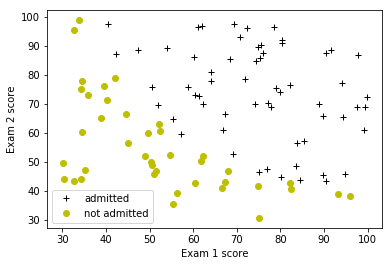

In [5]:
def plotData():
    fig,ax = plt.subplots()
    ax.plot(admitted[0],admitted[1],'k+',label='admitted')
    ax.plot(not_admitted[0],not_admitted[1],'yo',label='not admitted')
    plt.legend()
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')
plotData()
plt.show()

### 1.2 开始

#### 1.2.1 Sigmoid函数

In [6]:
from scipy.special import expit

In [7]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def h(theta,X):
    return expit(np.dot(X, theta))

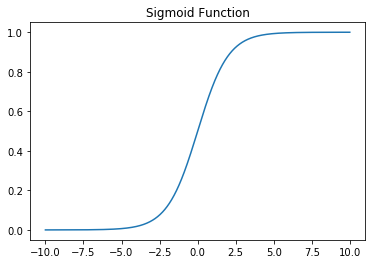

In [27]:
#检查sigmoid函数
myx = np.arange(-10,10,0.01)
plt.plot(myx,expit(myx))
plt.title('Sigmoid Function')
plt.show()

#### 1.2.2 代价函数和梯度

In [9]:
def computeCost(mytheta,myX,myy):
    term1 = np.dot(-np.array(myy).T,np.log(h(mytheta,myX)))
    term2 = np.dot((1-np.array(myy)).T,np.log(1-h(mytheta,myX)))
    return float( (1./m) * np.sum(term1 - term2) )

In [10]:
initial_theta = np.zeros((X.shape[1],1))
computeCost(initial_theta,X,y)

0.6931471805599452

In [11]:
initial_theta=np.zeros(X[0].size)
iterations = 50000

In [12]:
np.dot((h(initial_theta,X).reshape(m,1) - y).T,np.array(X[:,1]).reshape(m,1))

array([[-1200.92165893]])

使用梯度下降法求解

In [13]:
#theta_star 是一维的array
def gradientDescent(theta_star,X,y,alpha=0.001,iterations=1000000):
    theta = theta_star
    jvec = []
    m=y.size
    for i in range(iterations):
        tem_theta = theta
        for j in range(len(theta)):
            tem_theta[j] = theta[j] - (alpha/m)*np.sum(np.dot((h(theta,X).reshape(m,1) - y).T,np.array(X[:,j]).reshape(m,1)))
        theta = tem_theta
        jvec.append(computeCost(theta,X,y))
    return theta, jvec

In [22]:
a,b = gradientDescent(np.zeros((X.shape[1],1)),X,y,0.001,1000000)

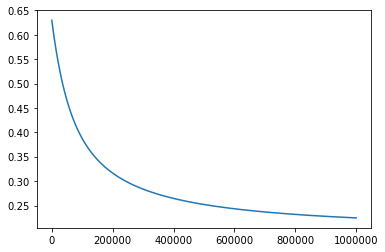

In [23]:
plt.plot(range(1000000),b)
plt.show()

使用scipy库中optimize.fmin函数求解

In [14]:
from scipy import optimize

In [15]:
theta = optimize.fmin(computeCost,initial_theta, args=(X, y))

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287


In [16]:
theta

array([-25.16130062,   0.20623142,   0.20147143])

画出边界(bondary)

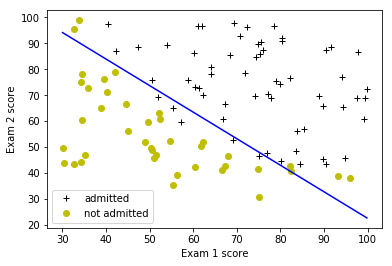

In [17]:
boundary_xs = np.array([np.min(X[:,1]), np.max(X[:,1])])
boundary_ys = (-1./theta[2])*(theta[0] + theta[1]*boundary_xs)
plotData()
plt.plot(boundary_xs,boundary_ys,'b-')
plt.legend()
plt.show()

查看准确率

In [18]:
pos = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
neg = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])

def makePrediction(mytheta, myx):
    return h(mytheta,myx) >= 0.5

pos_correct = np.sum(makePrediction(theta,pos))
neg_correct = float(np.sum(np.invert(makePrediction(theta,neg))))
prcnt_correct = float(pos_correct+neg_correct)/m
print("Fraction of training samples correctly predicted: %f." % prcnt_correct)

Fraction of training samples correctly predicted: 0.890000.


## 正则化逻辑回归

In [19]:
data2 = pd.read_table('data/ex2data2.txt',sep=',',header=None)
X = data2.iloc[:,:-1].values
y = data2.iloc[:,-1].values
m = y.size
X = np.insert(X,0,1,axis=1)
y = y.reshape((m,1))

In [20]:
pos = np.array([X[i] for i in range(len(X)) if y[i] == 1])
neg = np.array([X[i] for i in range(len(X)) if y[i] == 0])

数据可视化

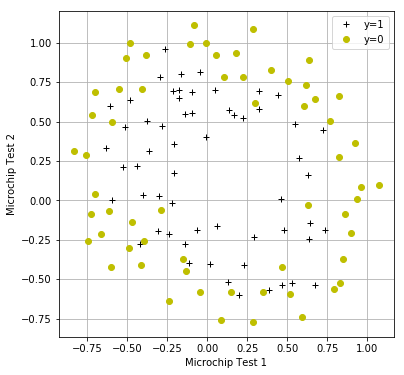

In [21]:
def plotData():
    plt.plot(pos[:,1],pos[:,2],'k+',label='y=1')
    plt.plot(neg[:,1],neg[:,2],'yo',label='y=0')
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.legend()
    plt.grid(True)
plt.figure(figsize=(6,6))
plotData()

In [60]:
#这段代码是从网上获取的，通过乘方把两个变量变为28个高阶变量
def mapFeature( x1col, x2col ):
    """ 
    Function that takes in a column of n- x1's, a column of n- x2s, and builds
    a n- x 28-dim matrix of featuers as described in the homework assignment
    """
    degrees = 6
    out = np.ones( (x1col.shape[0], 1) )

    for i in range(1, degrees+1):
        for j in range(0, i+1):
            term1 = x1col ** (i-j)
            term2 = x2col ** (j)
            term  = (term1 * term2).reshape( term1.shape[0], 1 ) 
            out   = np.hstack(( out, term ))
    return out

In [23]:
#创建经过特征变换的矩阵
mappedX = mapFeature(X[:,1],X[:,2])

代价函数与上个例子的十分接近，就是增加了lamda正则项

In [82]:
def computeCost(mytheta,myX,myy,mylamda):
    term1 = np.dot(-np.array(myy).T,np.log(h(mytheta,myX)))
    term2 = np.dot((1-np.array(myy)).T,np.log(1-h(mytheta,myX)))
    regterm = (mylamda/2)*np.sum(np.dot(mytheta[1:].T,mytheta[1:]))
    return float( (1./m) * (np.sum(term1 - term2) + regterm))

In [92]:
initial_theta = np.zeros((mappedX.shape[1],1))
computeCost(initial_theta,mappedX,y,0)

0.6931471805599453

使用optimize.minimize求解theta，因为optimize.fmin已经超变量个数了

In [100]:
def optimizeRegularizeTheta(mytheta, myX, myy, mylamda=1):
    result = optimize.minimize(computeCost, mytheta, args=(myX, myy, mylamda))
    return np.array(result.x), result.fun

theta, mincost = optimizeRegularizeTheta(initial_theta,mappedX,y)

画出决策边界(decision boundary)

In [123]:
def plotBoundary(mytheta, myX, myy, mylambda=0.):
    """
    用于画出各lamda值的决策边界图，此函数包含了特征变换、正则化下求解theta。
    """
    theta, mincost = optimizeRegularizeTheta(mytheta,myX,myy,mylambda)
    xvals = np.linspace(-1,1.5,50)
    yvals = np.linspace(-1,1.5,50)
    zvals = np.zeros((len(xvals),len(yvals)))
    for i in range(len(xvals)):
        for j in range(len(yvals)):
            myfeaturesij = mapFeature(np.array([xvals[i]]),np.array([yvals[j]]))
            zvals[i][j] = np.dot(theta,myfeaturesij.T)
    zvals = zvals.transpose()
    mycontour = plt.contour( xvals, yvals, zvals, [0])
    #Kind of a hacky way to display a text on top of the decision boundary
    myfmt = { 0:'Lambda = %d'%mylambda}
    plt.clabel(mycontour, inline=1, fontsize=15, fmt=myfmt)
    plt.title("Decision Boundary")

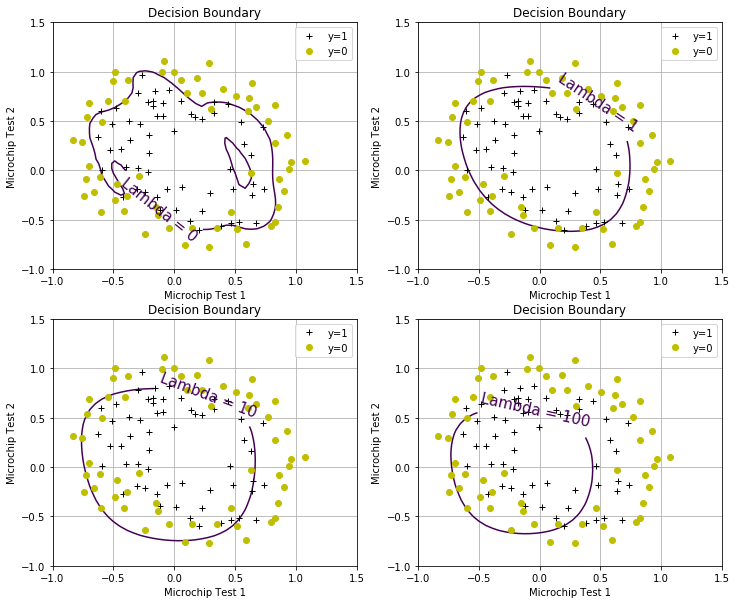

In [125]:
#Build a figure showing contours for various values of regularization parameter, lambda
#It shows for lambda=0 we are overfitting, and for lambda=100 we are underfitting
plt.figure(figsize=(12,10))
plt.subplot(221)
plotData()
plotBoundary(theta,mappedX,y,0.)

plt.subplot(222)
plotData()
plotBoundary(theta,mappedX,y,1.)

plt.subplot(223)
plotData()
plotBoundary(theta,mappedX,y,10.)

plt.subplot(224)
plotData()
plotBoundary(theta,mappedX,y,100.)